In [120]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [104]:
attractions = pd.read_csv('C:/VSCode/EDA/data/관광지정보.csv', encoding='cp949')
infos       = pd.read_csv('C:/VSCode/EDA/data/관광안내소.csv', encoding='cp949')
lodgings    = pd.read_csv('C:/VSCode/EDA/data/관광펜션업소.csv', encoding='cp949')
lodgings = lodgings[ lodgings['상세영업상태명'] == '영업중' ].copy()
lodgings = lodgings.dropna(
    subset=['좌표정보x(epsg5174)', '좌표정보y(epsg5174)']
).reset_index(drop=True)

In [105]:
gdf_attr = gpd.GeoDataFrame(
    attractions, 
    geometry=gpd.points_from_xy(attractions['경도'], attractions['위도']), 
    crs='EPSG:4326'
)
gdf_info = gpd.GeoDataFrame(
    infos, 
    geometry=gpd.points_from_xy(infos['경도'], infos['위도']), 
    crs='EPSG:4326'
)
gdf_lodge = gpd.GeoDataFrame(
    lodgings,
    geometry=gpd.points_from_xy(
        lodgings['좌표정보x(epsg5174)'], 
        lodgings['좌표정보y(epsg5174)']
    ),
    crs='EPSG:5174'
)

In [106]:
gdf_attr_proj  = gdf_attr.to_crs(epsg=5174)
gdf_info_proj  = gdf_info.to_crs(epsg=5174)

In [107]:
radius = 1000  # 미터 단위
gdf_attr_proj['buffer'] = gdf_attr_proj.geometry.buffer(radius)

buff = gpd.GeoDataFrame(geometry=gdf_attr_proj['buffer'], crs=gdf_attr_proj.crs)
join_info = gpd.sjoin(buff, gdf_info_proj, how='left', predicate='contains')
info_counts = join_info.groupby(join_info.index).size()
gdf_attr_proj['info_count'] = gdf_attr_proj.index.map(info_counts).fillna(0).astype(int)

join_lodge = gpd.sjoin(buff, gdf_lodge, how='left', predicate='contains')
lodge_counts = join_lodge.groupby(join_lodge.index).size()
gdf_attr_proj['lodge_count'] = gdf_attr_proj.index.map(lodge_counts).fillna(0).astype(int)

In [108]:
gdf_attr_final = gdf_attr_proj.to_crs(epsg=4326)
gdf_info_4326  = gdf_info_proj.to_crs(epsg=4326)
gdf_lodge_4326 = gdf_lodge.to_crs(epsg=4326)

In [109]:
center = [gdf_attr_final.geometry.y.mean(), gdf_attr_final.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=11)

In [110]:
for _, r in gdf_attr_final.iterrows():
    folium.CircleMarker(
        location=[r.geometry.y, r.geometry.x],
        radius=3,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7
    ).add_to(m)

for _, r in gdf_info_4326.iterrows():
    folium.CircleMarker(
        location=[r.geometry.y, r.geometry.x],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7
    ).add_to(m)

for _, r in gdf_lodge_4326.iterrows():
    folium.CircleMarker(
        location=[r.geometry.y, r.geometry.x],
        radius=3,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7
    ).add_to(m)

In [111]:
map_path = 'C:/VSCode/EDA/data/tourism_coverage_map.html'
m.save(map_path)
print(f"지도 파일이 '{map_path}'에 저장되었습니다. 해당 파일을 브라우저로 열어 결과를 확인하세요.")

지도 파일이 'C:/VSCode/EDA/data/tourism_coverage_map.html'에 저장되었습니다. 해당 파일을 브라우저로 열어 결과를 확인하세요.


In [112]:
sig = gpd.read_file('C:/VSCode/EDA/data/시군구/sig.shp', encoding='euc-kr').to_crs(epsg=4326)

In [113]:
center = [gdf_attr_final.geometry.y.mean(), gdf_attr_final.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=8)

In [114]:
folium.GeoJson(
    data=sig,
    name='행정구역',
    style_function=lambda feature: {
        'fillColor': 'none',
        'color': 'black',
        'weight': 1
    }
).add_to(m)

In [115]:
for _, r in gdf_attr_final.iterrows():
    folium.CircleMarker(
        [r.geometry.y, r.geometry.x],
        radius=4, color='red', fill=True, fill_color='red', fill_opacity=0.7
    ).add_to(m)
for _, r in gdf_info_4326.iterrows():
    folium.CircleMarker(
        [r.geometry.y, r.geometry.x],
        radius=3, color='blue', fill=True, fill_color='blue', fill_opacity=0.7
    ).add_to(m)
for _, r in gdf_lodge_4326.iterrows():
    folium.CircleMarker(
        [r.geometry.y, r.geometry.x],
        radius=3, color='green', fill=True, fill_color='green', fill_opacity=0.7
    ).add_to(m)

In [116]:
folium.LayerControl().add_to(m)

# 6) 저장
output_path = 'tourism_with_boundaries.html'
m.save(output_path)
print(f"지도가 '{output_path}'에 저장되었습니다. 확인해 보세요.")

지도가 'tourism_with_boundaries.html'에 저장되었습니다. 확인해 보세요.


In [ ]:
attr_join = gpd.sjoin(
    gdf_attr_final,            
    sig[['SIG_KOR_NM','geometry']], 
    how='left',
    predicate='within'
).rename(columns={'SIG_KOR_NM':'region'})

info_join = gpd.sjoin(
    gdf_info_4326, 
    sig[['SIG_KOR_NM','geometry']],
    how='left', predicate='within'
).rename(columns={'SIG_KOR_NM':'region'})

lodge_join = gpd.sjoin(
    gdf_lodge_4326, 
    sig[['SIG_KOR_NM','geometry']],
    how='left', predicate='within'
).rename(columns={'SIG_KOR_NM':'region'})

In [ ]:
attr_cnt  = attr_join .groupby('region').size().rename('n_attraction')
info_cnt  = info_join .groupby('region').size().rename('n_info')
lodge_cnt = lodge_join.groupby('region').size().rename('n_lodge')

counts = pd.concat([attr_cnt, info_cnt, lodge_cnt], axis=1).fillna(0)

eps = 1e-6
counts['ratio_info']  = counts['n_attraction'] / (counts['n_info']  + eps)
counts['ratio_lodge'] = counts['n_attraction'] / (counts['n_lodge'] + eps)

sig_counts = sig.merge(
    counts, left_on='SIG_KOR_NM', right_index=True, how='left'
).fillna(0)

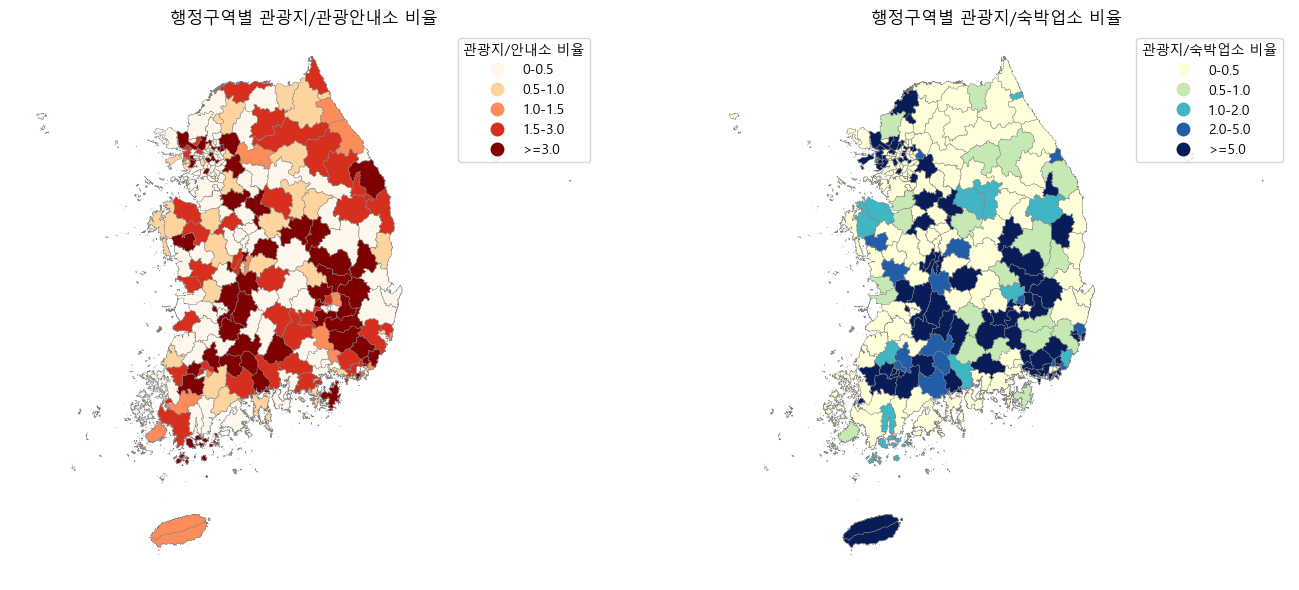

In [ ]:
info_bins = [0, 0.5, 1.0, 1.5, 3.0, float("inf")]
info_labels = ['0-0.5', '0.5-1.0', '1.0-1.5', '1.5-3.0', '>=3.0']
lodge_bins = [0, 0.5, 1.0, 2.0, 5.0, float("inf")]
lodge_labels = ['0-0.5', '0.5-1.0', '1.0-2.0', '2.0-5.0', '>=5.0']

sig_counts['info_cat']  = pd.cut(sig_counts['ratio_info'],  bins=info_bins,  labels=info_labels,  include_lowest=True)
sig_counts['lodge_cat'] = pd.cut(sig_counts['ratio_lodge'], bins=lodge_bins, labels=lodge_labels, include_lowest=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sig_counts.plot(
    column='info_cat',
    categorical=True,
    legend=True,
    legend_kwds={'title': '관광지/안내소 비율'},
    cmap='OrRd',
    edgecolor='gray',
    linewidth=0.3,
    ax=axes[0]
)
axes[0].set_title('행정구역별 관광지/관광안내소 비율')
axes[0].axis('off')

sig_counts.plot(
    column='lodge_cat',
    categorical=True,
    legend=True,
    legend_kwds={'title': '관광지/숙박업소 비율'},
    cmap='YlGnBu',
    edgecolor='gray',
    linewidth=0.3,
    ax=axes[1]
)
axes[1].set_title('행정구역별 관광지/숙박업소 비율')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
n = 5

df_info = sig_counts[['SIG_KOR_NM','ratio_info']].copy()
df_lodge = sig_counts[['SIG_KOR_NM','ratio_lodge']].copy()

top_info    = df_info .sort_values('ratio_info',  ascending=False).head(n)
bottom_info = df_info .sort_values('ratio_info',  ascending=True ).head(n)

top_lodge    = df_lodge.sort_values('ratio_lodge', ascending=False).head(n)
bottom_lodge = df_lodge.sort_values('ratio_lodge', ascending=True ).head(n)

top_info    = top_info   .rename(columns={'SIG_KOR_NM':'행정구역','ratio_info':'관광지/안내소 비율'})
bottom_info = bottom_info.rename(columns={'SIG_KOR_NM':'행정구역','ratio_info':'관광지/안내소 비율'})
top_lodge    = top_lodge  .rename(columns={'SIG_KOR_NM':'행정구역','ratio_lodge':'관광지/숙박 비율'})
bottom_lodge = bottom_lodge.rename(columns={'SIG_KOR_NM':'행정구역','ratio_lodge':'관광지/숙박 비율'})

print(f"=== 관광지/관광안내소 비율 상위 {n}개 ===")
print(top_info.to_string(index=False), '\n')

print(f"=== 관광지/관광안내소 비율 하위 {n}개 ===")
print(bottom_info.to_string(index=False), '\n')

print(f"=== 관광지/숙박업소 비율 상위 {n}개 ===")
print(top_lodge.to_string(index=False), '\n')

print(f"=== 관광지/숙박업소 비율 하위 {n}개 ===")
print(bottom_lodge.to_string(index=False))

=== 관광지/관광안내소 비율 상위 5개 ===
행정구역  관광지/안내소 비율
 나주시  22000000.0
 김포시  11000000.0
 칠곡군  10000000.0
 군포시   6000000.0
 서초구   6000000.0 

=== 관광지/관광안내소 비율 하위 5개 ===
   행정구역  관광지/안내소 비율
    종로구         0.0
수원시 장안구         0.0
세종특별자치시         0.0
청주시 상당구         0.0
청주시 서원구         0.0 

=== 관광지/숙박업소 비율 상위 5개 ===
행정구역  관광지/숙박 비율
 용산구 42000000.0
  서구 16000000.0
  서구 16000000.0
  서구 16000000.0
  서구 16000000.0 

=== 관광지/숙박업소 비율 하위 5개 ===
   행정구역  관광지/숙박 비율
    종로구        0.0
용인시 수지구        0.0
    이천시        0.0
    화성시        0.0
    계양구        0.0


In [131]:
n = 50
# 안내소 부족 하위 n개
bottom_info = (
    gdf_attr_proj 
    .nsmallest(n, 'info_count')
    [['관광지명','info_count']]
    .rename(columns={'관광지명':'관광지','info_count':'안내소개수'})
)
# 숙박업소 부족 하위 n개
bottom_lodge = (
    gdf_attr_proj 
    .nsmallest(n, 'lodge_count')
    [['관광지명','lodge_count']]
    .rename(columns={'관광지명':'관광지','lodge_count':'숙박업소개수'})
)

print("=== 안내소 부족 관광지 하위 5개 ===")
print(bottom_info.to_string(index=False), "\n")

print("=== 숙박업소 부족 관광지 하위 5개 ===")
print(bottom_lodge.to_string(index=False))

=== 안내소 부족 관광지 하위 5개 ===
            관광지  안내소개수
       아산조방원미술관      1
        곡성생태체험관      1
        심청효문화센터      1
       심청골짝나라학교      1
         심청한옥마을      1
       곡성청소년야영장      1
곡성기차마을 패러글라이딩체험      1
      섬진강 레일바이크      1
          문동휴양지      1
          바람의언덕      1
         우제봉전망대      1
          청마기념관      1
            씨월드      1
        알로에테마파크      1
       노을이물드는언덕      1
       가조수협효시공원      1
       담양호국민관광지      1
         부석사관광지      1
      요트올림픽동산지구      1
            동백섬      1
            몰운대      1
    다대포 꿈의 낙조분수      1
        다대포해수욕장      1
    낙동강하구아미산전망대      1
       을숙도 생태공원      1
       을숙도 철새공원      1
         감천문화마을      1
           장림포구      1
           쌍암공원      1
         수완호수공원      1
        송정작은미술관      1
        소촌아트팩토리      1
    별밤미술관 in 첨단      1
    별밤미술관 in 수완      1
    별밤미술관 in 운남      1
    별밤미술관 in 신창      1
    별밤미술관 in 선운      1
        순천향매실마을      1
         순천생태마을      1
       거차뻘배체험마을      1
      낙안민속자연휴양림      1
         